# Cross-Entropy Method

---

In this notebook, we will train the Cross-Entropy Method with OpenAI Gym's MountainCarContinuous environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### 2. Instantiate the Environment and Agent

In [8]:
env = gym.make('MountainCarContinuous-v0')
env.seed(69)
np.random.seed(69)

print(f'Obs Space: {env.observation_space}')
print(f'Act Space: {env.action_space}')
env.observation_space.shape
env.action_space.shape

Obs Space: Box(2,)
Act Space: Box(1,)


(1,)

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Agent(nn.Module):
    def __init__(self, env, hidden_size=16):
        super().__init__()
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(self.state_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.action_size)
        self.net = nn.Sequential(
            self.fc1,
            nn.ReLU(), 
            self.fc2,
            nn.Tanh()
        )
    
    def set_weights(self, weights):
        # separate the weights for each layer
        state_size = self.state_size
        action_size = self.action_size
        hidden_size = self.hidden_size

        sxh = state_size*hidden_size
        hxa = hidden_size*action_size

        fc1_W_idc = np.s_[:sxh]
        fc1_b_idc = np.s_[sxh:sxh+hidden_size]
        fc2_W_idc = np.s_[sxh+hidden_size:sxh+hidden_size+hxa]
        fc2_b_idc = np.s_[sxh+hidden_size+hxa:]

        fc1_W = weights[fc1_W_idc].reshape(state_size, hidden_size)
        fc1_b = weights[fc1_b_idc]
        fc2_W = weights[fc2_W_idc].reshape(hidden_size, action_size)
        fc2_b = weights[fc2_b_idc]

        fc1_W, fc1_b, fc2_W, fc2_b = map(torch.from_numpy, [fc1_W, fc1_b, fc2_W, fc2_b])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
        

    @property
    def weights_dim(self):
        fc1_dim = (self.state_size + 1) * self.hidden_size 
        fc2_dim = (self.hidden_size + 1) * self.action_size
        return fc1_dim + fc2_dim
    
    def forward(self, x):
        return self.net(x)

    def evaluate(self, weights, gamma=1.0, num_steps=5000):
        self.set_weights(weights)
        episode_return = 0

        state = self.env.reset()
        
        for t in range(num_steps):
            
            state = torch.from_numpy(state).float().to(device)
            action = self(state).cpu().data
            state, reward, done, _ = self.env.step(action)

            episode_return += reward * math.pow(gamma, t)
            if done: break
        
        return episode_return


### 3. Train the Agent with the Cross-Entropy Method

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [54]:
agent = Agent(env).to(device)

def cem(num_iterations=500, num_steps=1000, gamma=1.0, popu_size=50, elite_frac=0.2, sigma=0.5):
    num_elites = int(popu_size * elite_frac)
    best_weight = sigma * np.random.randn(agent.weights_dim)

    scores_deque = deque(maxlen=100)
    scores = []

    for i_iteration in range(1, num_iterations):
        popu_weights = [best_weight + sigma * np.random.randn(agent.weights_dim) for _ in range(popu_size)]
        popu_rewards = np.array([agent.evaluate(weights, gamma, num_steps) for weights in popu_weights])

        elite_idc = popu_rewards.argsort()[-num_elites:]
        elite_weights = [popu_weights[i] for i in elite_idc]
        best_weight = np.array(elite_weights).mean(0)

        score = agent.evaluate(best_weight, gamma)
        scores_deque.append(score)
        scores.append(score)

        torch.save(agent.state_dict(), 'checkpoint.pth')

        if i_iteration % 10 == 0:
            print(f'Episde {i_iteration} Average Score: {np.mean(scores_deque)}')

        if np.mean(scores_deque) >= 90:
            print(f'\nEnvironment solved in {i_iteration - 100}! Average score: {np.mean(scores_deque)}')
            break
    return scores
        


Episde 10 Average Score: -4.5170450874469195
Episde 20 Average Score: -1.4981566527286634
Episde 30 Average Score: 27.411896556700334
Episde 40 Average Score: 40.118285594590674
Episde 50 Average Score: 50.96959618156379
Episde 60 Average Score: 58.041333610902015
Episde 70 Average Score: 63.05928176033476
Episde 80 Average Score: 66.96560327141813
Episde 90 Average Score: 69.93524769618519
Episde 100 Average Score: 72.34348925580585
Episde 110 Average Score: 82.25657355067032

Environment solved in 18! Average score: 90.88090403169086


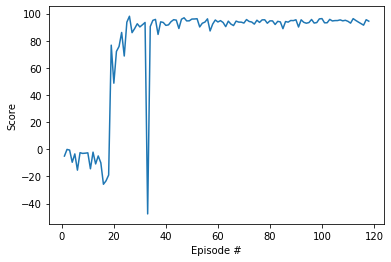

In [55]:
scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [56]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

NoSuchDisplayException: Cannot connect to "None"